In [3]:
from typing import Optional
from dataclasses import dataclass
import pickle
from datetime import datetime as dt
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
import os

### Necesarry Helper Functions

In [4]:
@dataclass
class Form:
    # Same for both sources
    filing_date: str
    trade_date: str
    ticker: str
    price: float
    qty_bought: float
    qty_owned: float

    #Source: openinsider.com
    insider_name_link: Optional[str] = None 
    company_link: Optional[str] = None
    buyer_title: Optional[str] = None
    
    #Source: SEC Bulk Data
    accession_number: Optional[str] = None
    insider_name: Optional[str] = None 
    company_name: Optional[str] = None
    insider_relationship: Optional[str] = None 
    insider_title: Optional[str] = None 
    fd_index: Optional[int] = None

    def __eq__(self, other) -> bool:
        return self.filing_date == other.filing_date and self.trade_date == other.trade_date and self.ticker == other.ticker and self.price == other.price and self.qty_bought == other.qty_bought and self.qty_owned == self.qty_owned
    
    def __ne__(self, other) -> bool:
        return not self.__eq__(other)
    
    def delta_own(self):
        if self.qty_owned is None or self.qty_bought is None: raise ValueError("Class values were None")

        if self.qty_owned - self.qty_bought == 0:
            return 100
        else:
            return float(self.qty_bought / (self.qty_owned - self.qty_bought)) * 100

    def days_ago(self) -> int:
        if self.filing_date is None or self.trade_date is None:
            raise ValueError("Class values were None")
        fd = dt.strptime(self.filing_date, "%Y-%m-%d")
        td = dt.strptime(self.trade_date,  "%Y-%m-%d")
        return (fd - td).days
  
def save_data(data, fname):
    """
    base path is Assets folder
    """
    with open(f"Assets/{fname}.pkl", "wb") as file:
        pickle.dump(data, file)

def load_data(fname) -> list:
    with open(f"Assets/{fname}.pkl", "rb") as file:
        data = pickle.load(file)
        return data

def tickers_from_data(forms: list[Form]):
    tickers = {}
    for form in forms:
        tickers[form.ticker] = 1

    return [key for key in tickers.keys()]

@dataclass
class Candle:
    date: str
    o: float
    c: float
    h: float
    l: float
    v: int


@dataclass(repr=False)
class Trade:
    form: Form
    candles: list[Candle]
    onem_profit: Optional[float] = None
    twom_profit: Optional[float] = None
    threem_profit: Optional[float] = None

    def __repr__(self) -> str:
        return f"{self.form.insider_name} ({self.form.insider_relationship}): {self.form.qty_bought} {self.form.ticker} @ {self.form.price} on {self.form.filing_date} ({self.form.accession_number})"

    def catalyst_size(self, shift):
        """
        NOTE: candles[0] needs to be at the filing date, and candles[-1] should be the final day\n
        @param n_days is how many days after the filing date the calculations should consider\n
        @param shift is how many days each peak should be shifted to the right by
        """
        avg_peak_val: float = 0.0

        closes = [c.c for c in self.candles]
        _, peaks = get_peaks(closes, shift)
        
        if len(peaks) != 0:
            for peak in peaks:
                avg_peak_val += self.candles[peak].c
                # print(f"{self.candles[peak].c}, {peak}")
            avg_peak_val /= len(peaks)
            # print(f"AVG PEAK: {avg_peak_val}")
            # print(f"First Close: {self.candles[0].c}")
            return pct_change(self.candles[0].c, avg_peak_val)
        
        # if there are no peaks (sad face), return absolute change
        return pct_change(closes[0], closes[-1])
    
    def returns(self, days: int, candles: list[Candle] = []) -> float:
        """
        Percent return over (@param days) number of days from close to close\n
        Negative days shows past returns up to the filing date\n
        Used to check the passivity of a certain transaction\n
        """
        if days > 0:
            if len(self.candles) > days:
                return pct_change(self.candles[0].c, self.candles[days - 1].c)
            
        data = []
        if len(candles) == 0:
            data = get_ticker_data(self.form.ticker)
            assert data is not None
        else: 
            data = candles

        fdi = self.form.fd_index
        assert fdi is not None
    
        if days < 0:
            data = trim_ticker_data(data, fdi, (-days, 1))
        elif days > 0:
            data = trim_ticker_data(data, fdi, (0, days))
        else: return 0

        return pct_change(data[0].c, data[-1].c)
    
def moving_avg(data: list, length: int):
    new_data = []
    window = []
    for d in data:
        if len(window) <= length:
            window.append(d)
        else:
            window = window[1:]
            window.append(d)

        new_data.append(sum(window)/len(window))
    return new_data

def pct_change(from_, to_):
    return ((to_ - from_) / from_) * 100

def get_peaks(price_data: list, shift: int):
    """
    @param price_data: list of prices (typically the closing prices)\n
    @param shift: move each peak to the right n-days because seldom will you exit at the true peak of a stock\n
    """
    ma = moving_avg(price_data, 7)

    dist = 7
    height_multiplier = 1.05
    peaks, _ = find_peaks(ma, distance=dist, height=ma[0] * height_multiplier, width=5) # one week between peaks and peak must be a 5% increase from day 0


    while len(peaks) == 0 and dist >= 1:
        peaks, _ = find_peaks(ma, distance=dist, width=5) # one week between peaks and peak must be a 5% increase from day 0
        dist -= 1

    if pct_change(ma[0], ma[-1]) > 5:
        peaks = list(peaks)

        s = 0.0
        for p in peaks:
            s += ma[p]

        avg_peak_height = s/len(peaks)
        if ma[-2] > avg_peak_height:
            peaks.append(len(ma) - 2) # add second index from the end

    if len(peaks) == 0: return [], []

    for i in range(len(peaks)):
        if i < len(peaks) - 1:
            peaks[i] += shift 

    return ma, peaks

def show_trade(trade: Trade, show_peaks: bool):
    prices = pd.DataFrame({
        "high"  : [candle.h  for candle in trade.candles],
        "low"   : [candle.l  for candle in trade.candles],
        "open"  : [candle.o  for candle in trade.candles],
        "close" : [candle.c  for candle in trade.candles]
    })
    green  = prices[prices.close >= prices.open] # green candles
    red    = prices[prices.close < prices.open] # red candles
    w1, w2 = 0.4, 0.02 # width of thick part and width of extrema

    _, ax = plt.subplots()
    # graph green candles (x, height, width, bottom, color)
    ax.bar(green.index, green.close - green.open, w1, green.open, color='green') # thick middle part
    ax.bar(green.index, green.high  - green.close, w2, green.close, color='black') # high price
    ax.bar(green.index, green.low  - green.open, w2, green.open, color='black') # low price
    
    ax.bar(red.index, red.close - red.open, w1, red.open, color='red') # thick middle part
    ax.bar(red.index, red.high  - red.open, w2, red.open, color='black') # high price
    ax.bar(red.index, red.low   - red.close, w2, red.close, color='black') # low price

    if show_peaks:
        ma, peaks = get_peaks(list(prices.close.array), 3)
        ax.plot(ma)
        
        for peak in peaks:
            ax.plot(peak, list(prices.close.array)[peak], "bo")


    title = f"{trade.form.ticker} @ {trade.candles[0].date} (FD: {trade.form.filing_date}, TD: {trade.form.trade_date})"

    ax.set_title(title)
    plt.show()

def get_ticker_data(ticker: str):
    """
    open and return the data associated with a certain ticker\n
    returns None is no data are found
    """
    contents = os.listdir(f"Assets/Historical_Stock_Data")
    if f"{ticker}.pkl" not in contents: return None
    else: return load_data(f"Historical_Stock_Data/{ticker}")

def trim_ticker_data(data: list[Candle], fd_index: int, window: tuple[int, int]):
    """
    @param window is a tuple of how many candles should be included before and after the filing date\n
    \t --> i.e. (10, 100) means to show from 10 days before to 100 days after
    """
    start = fd_index - window[0] if fd_index - window[0] >= 0 else 0
    end = fd_index + window[1] if fd_index + window[1] < len(data) else len(data) - 1
    data = data[start : end]
    return data

def trade_from_histform(form: Form, n_days):
    """
    returns trade object with candles from fd up to (fd + n_days)
    """
    data = get_ticker_data(form.ticker)
    if data is None: return

    i = form.fd_index
    if i is None: 
        print("❌FDI NOT FOUND")
        return

    data = data[i:i + n_days]

    trade = Trade(
        form,
        data
    )

    return trade

def show_hist_trade(form: Form, n_days: int, show_peaks: bool):
    if form.ticker is None: return
    if form.filing_date is None: return

    data = get_ticker_data(form.ticker)
    if data is None: return

    i = form.fd_index
    if i is None: 
        print("❌FDI NOT FOUND")
        return

    data = data[i : i + n_days]

    trade = Trade(
        form,
        data
    )

    show_trade(trade, show_peaks)

    return trade

### Load in Data

In [4]:
forms: list[Form] = load_data("HistForms")

In [6]:
l = len(forms)
trades: list[Trade] = []
for i, form in enumerate(forms):
    print(f"{i/(l - 1)*100:.2f}%", end='\r')
    t = trade_from_histform(form, 100)
    if t is not None: # * this line ensures each trade has data!
        trades.append(t)

trades = list(filter(lambda x: len(x.candles) > 0 and x.candles is not None, trades)) # filter such that...

In [9]:
trades: list[Trade] = load_data("Trades")

### Track the Insider and Company in Question

In [5]:
def get_insider_and_company_dict(trades: list[Trade]) -> tuple[dict[str, list[Trade]], dict[str, list[Trade]]]:
    # get dictionary of "insider name" : [forms...]
    insider_dict: dict[str, list[Trade]] = {}
    # get dictionary of "ticker" : [forms...]
    company_dict: dict[str, list[Trade]] = {}

    for trade in trades:
        iname = trade.form.insider_name
        if iname is None: continue
        if iname not in insider_dict:
            insider_dict[iname] = [trade]
        else:
            insider_dict[iname].append(trade)

        cname = trade.form.ticker
        if cname is None: continue
        if cname not in company_dict:
            company_dict[cname] = [trade]
        else:
            company_dict[cname].append(trade)
        
    return insider_dict, company_dict

In [6]:
def get_cluster_score(curr: Trade, company_trades: list[Trade]):
    cd = dt.strptime(curr.form.trade_date, "%Y-%m-%d")

    cluster_score = 0

    # filter such that every trade in the comapnies history is from before the current trades filing date
    for t in list(filter(lambda x: dt.strptime(x.form.trade_date, "%Y-%m-%d") <= cd and x.form.accession_number != curr.form.accession_number, company_trades)):
        td = dt.strptime(t.form.trade_date, "%Y-%m-%d")
        if (cd - td).days < 30:
            cluster_score += 1
    
    return cluster_score

### Map Insider Job Title to Numbers

- Other = 1
- 10% owners = 2
- Director = 3
- Officer = 4
- Vice President (EVP or SVP) = 5
- President = 6

In [7]:
def map_insider_title(relationship: str, title: str = "") -> int:
    relationship = relationship.lower()

    if "other" in relationship:
        return 1

    if "tenpercentowner" in relationship:
        return 2
    
    if "director" in relationship:
        return 3
    
    if "officer" in relationship:
        if title == "": return 4
        t = title.lower()

        if "vice president" in t or "svp" in t or "evp" in t:
            # must be before the check for president
            return 5
        
        if "president" in t:
            return 6
        
        return 4 # shouldn't be reached

    #* tested on all forms and never reached
    return 0

## Conduct Analysis

In [8]:
import pandas as pd

#### Import data into a pandas dataframe
First it needs to be created and then saved to csv, where it can then be read in from said file (much quicker)

In [10]:
i_dict, c_dict = get_insider_and_company_dict(trades)

In [83]:
data = {
    "ticker": [],
    "insider_name": [],
    "qty_bought": [],
    "qty_owned": [],
    "share_price": [],
    "owner_title": [],
    "days_ago": [],
    "delta_own": [],
    "filing_date": [],
    "trade_date": [],
    "cluster_score": [],
    "returns(90)": [],
    "returns(-30)": [],
}

l = len(trades)
for i, t in enumerate(trades):
    print(f"{i / (l-1) * 100 :.2f}%", end='\r')
    try:
        data["returns(-30)"].append(t.returns(-30))
    except:
        continue

    f = t.form
    data["ticker"].append(f.ticker)
    data["insider_name"].append(f.insider_name)
    data["qty_bought"].append(f.qty_bought)
    data["qty_owned"].append(f.qty_owned)
    data["share_price"].append(f.price)
    data["owner_title"].append(f.insider_relationship)
    data["days_ago"].append(f.days_ago())
    data["delta_own"].append(f.delta_own())
    data["filing_date"].append(f.filing_date)
    data["trade_date"].append(f.trade_date)
    data["cluster_score"].append(get_cluster_score(t, c_dict[f.ticker]))
    data["returns(90)"].append(t.returns(90))

df = pd.DataFrame.from_dict(data)

In [11]:
df = pd.read_csv("Assets/DataFrame.csv")
df.dropna(inplace=True)
df.drop(df[df["delta_own"] < 0].index, inplace=True)
df.drop(columns=["Unnamed: 0"], inplace=True)

#### Visualize Data to Try and Observe Trends

In [12]:
def mean_w_bounds(column: str, bounds: list[float]) -> list[float]:
    assert column in df.columns

    means = []
    prev = -1
    for i, bound in enumerate(bounds):
        if i == 0:
            prev = bound
            continue

        lower = prev
        upper = bound

        means.append(df[(df[column] > lower) & (df[column] < upper)].loc[:, "returns(90)"].mean())

        if i == len(bounds) - 1:
            # compute the returns for (upper bound, ∞)
            lower = bound
            means.append(df[(df[column] > lower)].loc[:, "returns(90)"].mean())
            
        prev = bound

    return means

In [13]:
def plot_column_by_bounds(column: str, bounds: list[float]):
    _, ax = plt.subplots(figsize=(10, 3))
    x = [f"{bounds[i]:,.2f} to {x:,.2f}" for i, x in enumerate(bounds[1:])]
    x.append(f">{bounds[-1]:,.2f}")

    ax.bar(x=x, height=mean_w_bounds(column, bounds))
    ax.set_title(f"avg. returns(90) vs. {column}")
    ax.set_xlabel(f"Upper Bound of # of {column}")
    ax.set_ylabel("90 day returns (%)")
    plt.show()


#### Analyzing Quantity of Shares Bought
Strong positive correlation

In [39]:
df["qty_bought"].describe(percentiles=[0.25, 0.50, 0.75, 0.90])

count    3.764300e+04
mean     1.245640e+05
std      3.129793e+06
min      0.000000e+00
25%      3.150000e+02
50%      2.040000e+03
75%      1.000000e+04
90%      5.364700e+04
max      5.135352e+08
Name: qty_bought, dtype: float64

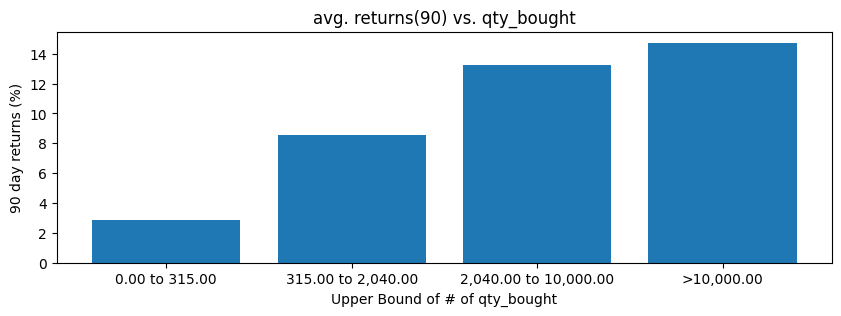

In [14]:
upper_bounds: list[float] = [0, 315, 2040, 10_000]
plot_column_by_bounds("qty_bought", upper_bounds)

#### Analyzing Percent Change in Ownership
Moderately strong linear relationship

In [17]:
df["delta_own"].describe()

count    3.757400e+04
mean     1.763230e+02
std      1.090989e+04
min      0.000000e+00
25%      4.464599e-01
50%      3.489516e+00
75%      2.500000e+01
max      1.676000e+06
Name: delta_own, dtype: float64

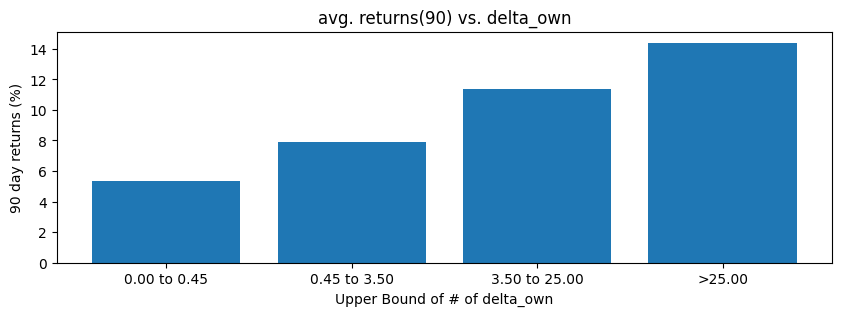

In [18]:
upper_bounds: list[float] = [0, 0.45, 3.5, 25]
plot_column_by_bounds("delta_own", upper_bounds)

#### Analyzing Share Price
Strong negative relationship (approx 1/x)

In [15]:
df["share_price"].describe(percentiles=[0.25, 0.50, 0.75, 0.90])

count    3.764300e+04
mean     1.269884e+03
std      7.464645e+04
min      0.000000e+00
25%      5.640000e+00
50%      1.475000e+01
75%      2.990000e+01
90%      6.374000e+01
max      6.000000e+06
Name: share_price, dtype: float64

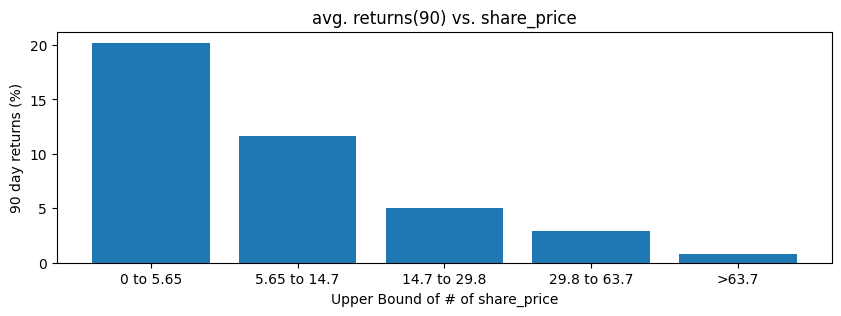

In [31]:
upper_bounds = [0, 5.64, 14.7, 29.8, 63.7] # 0, 25, 50, 75, 90 percentiles
plot_column_by_bounds("share_price", upper_bounds)

#### Analyzing Cluster Score
No trend established

In [26]:
df["cluster_score"].describe(percentiles=[0.25, 0.50, 0.75, 0.90])

count    37643.000000
mean        23.909014
std        101.526356
min          0.000000
25%          0.000000
50%          2.000000
75%          6.000000
90%         15.000000
max        803.000000
Name: cluster_score, dtype: float64

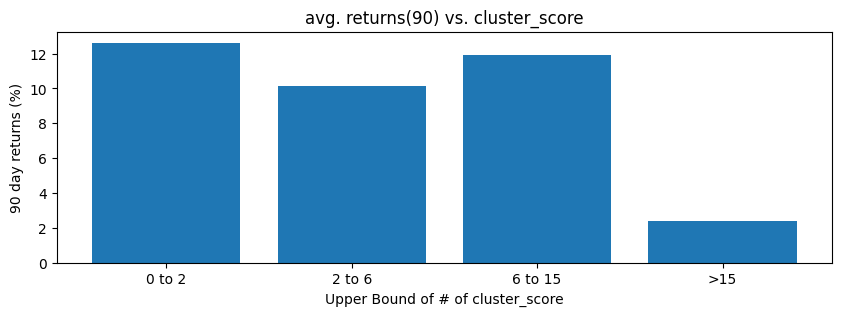

In [32]:
upper_bounds: list[float] = [0, 2, 6, 15]
plot_column_by_bounds("cluster_score", upper_bounds)

#### Analyzing Stock Returns Before Transaction Date

In [56]:
df["returns(-30)"].describe(percentiles=[0.25, 0.50, 0.75, 0.90])

count    3.757400e+04
mean     7.025127e+02
std      6.864768e+04
min     -9.428571e+01
25%     -1.411992e+01
50%     -2.085238e+00
75%      6.618837e+00
90%      2.012465e+01
max      7.209900e+06
Name: returns(-30), dtype: float64

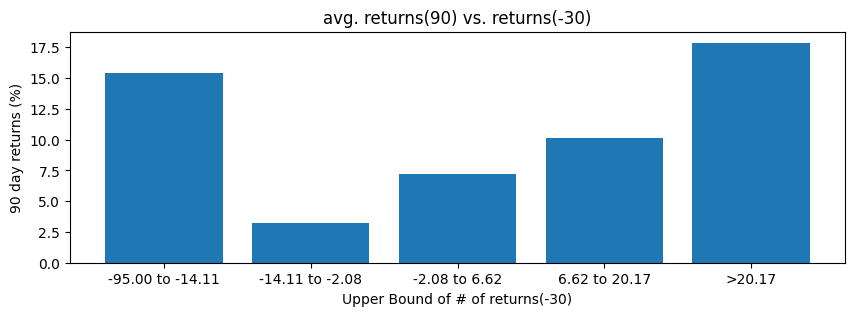

In [13]:
upper_bounds = [-95, -14.11, -2.08, 6.62, 20.17]
plot_column_by_bounds("returns(-30)", upper_bounds)

#### Analyzing Owner Relationship
Any owner besides "other" (mapped to 1) is fine

In [17]:
df["title_num"] = df["owner_title"].apply(lambda x: map_insider_title(str(x)))

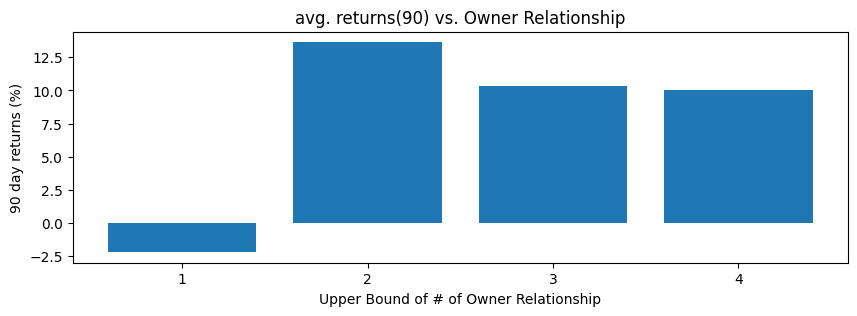

In [36]:
data = [
    df[df["title_num"] == 1].loc[:, "returns(90)"].mean(), df[df["title_num"] == 2].loc[:, "returns(90)"].mean(), 
    df[df["title_num"] == 3].loc[:, "returns(90)"].mean(), df[df["title_num"] == 4].loc[:, "returns(90)"].mean()
]
column = "Owner Relationship"
_, ax = plt.subplots(figsize=(10, 3))

ax.bar(x=["1", "2", "3", "4"], height=data)
ax.set_title(f"avg. returns(90) vs. {column}")
ax.set_xlabel(f"Upper Bound of # of {column}")
ax.set_ylabel("90 day returns (%)")
plt.show()

#### Analyze Insider Track Record

Filtering out the rows where the transaction price is not within the range of the past 5 years of stock data. Removed 2129 rows out of 37000 to ensure that profit calculations, especially the insider track record, are correct (and not above $4 trillion profit like it used to say)

In [17]:
def candle_max(data: list[Candle]):
    m = 0
    for d in data:
        m = d.h if d.h > m else m

    return m

def candle_min(data: list[Candle]):
    m = 1_000_000
    for d in data:
        m = d.l if d.l < m else m

    return m

In [18]:

#* Create a dictionary of <ticker> : (min, max price)
#* Will be used to remove invalid insider transactions
price_ranges: dict[str, tuple[float, float]] = {}
l = len(os.listdir("Assets/Historical_Stock_Data"))
for i,fname in enumerate(os.listdir("Assets/Historical_Stock_Data")):
    print(f"{i/l*100: .2f}%", end="\r")
    ticker = fname.split(".")[0]
    data = get_ticker_data(ticker)
    if data is None: continue

    price_ranges[ticker] = (candle_min(data), candle_max(data))



In [19]:
price_outliers = [] # INDEX of each price outlier, not the row itself
for i, row in df.iterrows():
    if row["share_price"] > price_ranges[row["ticker"]][1] or row["share_price"] < price_ranges[row["ticker"]][0]:
        price_outliers.append(i)

Here is where the indices of the price outliers are actually removed

In [20]:
df.drop(price_outliers, inplace=True)

In [21]:
def get_insider_record(name, fd):
    """
    Returns the average $ profit of a an insiders past trades
    """
    fd = dt.strptime(fd,  "%Y-%m-%d")
    # only include an insider's trades from the PAST
    i_trades = list(filter(lambda x: dt.strptime(x.form.filing_date, "%Y-%m-%d") < fd, i_dict[name]))
    
    i_profits = []
    for i_trade in i_trades:
        # must calculate the returns up to the filing date of the current trade to simulate placing a trade on that specific day
        if fd is None or i_trade.form.filing_date is None: continue

        #! key block for removing the stupid trades with incoherent price_per_share values
        if i_trade.form.price > price_ranges[i_trade.form.ticker][1] or i_trade.form.price < price_ranges[i_trade.form.ticker][0]:
            continue
        #!--------------------------------------------------------------------------------
        
        it_fd = dt.strptime(i_trade.form.filing_date, "%Y-%m-%d")
        delta = (fd - it_fd).days # correct

        if delta < 90:
            # because the difference between each candle is not always 1 day (weekends), returns(delta) is too far
            # into the future. Must find the index of teh desired filing date
            delta_index = -1
            for i, c in enumerate(i_trade.candles):
                if c.date == fd.strftime("%m/%d/%Y"):
                    delta_index = i
                    
            if delta_index == -1: continue
            new_price_per_share = i_trade.form.price + (i_trade.form.price * i_trade.returns(delta_index)/100)
        else:
            new_price_per_share = i_trade.form.price + (i_trade.form.price * i_trade.returns(90)/100)

        i_profits.append(
            (new_price_per_share - i_trade.form.price) * i_trade.form.qty_bought
        )

    if len(i_profits) > 0:
        return sum(i_profits)/len(i_profits)
    else:
        return 0

In [23]:
df["insider_record"] = df.apply(lambda row: get_insider_record(row["insider_name"], row["filing_date"]), axis=1)

In [24]:
# df["norm_insider_record"] = (df["insider_record"] - df["insider_record"].min()) / (df["insider_record"].max() - df["insider_record"].min()) 
df["insider_record"].describe(percentiles=[0.25, 0.50, 0.75, 0.90])

count    3.544500e+04
mean     1.150616e+04
std      1.269954e+06
min     -1.321910e+08
25%     -6.053106e+01
50%      0.000000e+00
75%      2.480730e+02
90%      1.188816e+04
max      6.814056e+07
Name: insider_record, dtype: float64

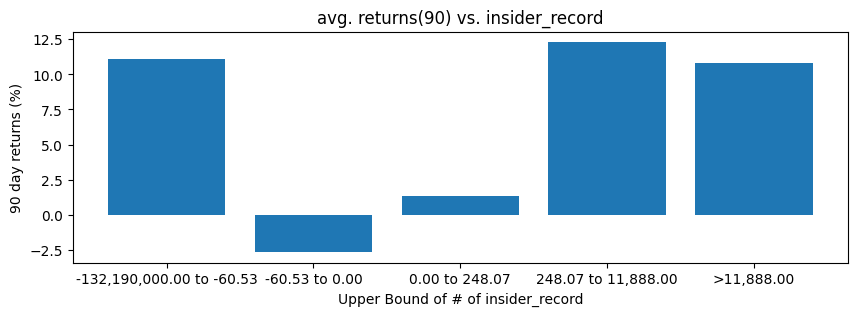

In [25]:
upper_bounds = [(-1.3219 * (10**8)), -60.53, 0, 248.07, 11_888]
plot_column_by_bounds("insider_record", upper_bounds)

#### Using the Best Parameters

In [18]:
rows = df[
    (df["share_price"] < 15) 
    & (df["qty_bought"] > 1_000_000) 
    & ((df["delta_own"] > 50) & (df["delta_own"] < 100))
    & (df["title_num"] != 1)
    & ((df["returns(-30)"] < -14) | (df["returns(-30)"] > 6.5))
    # & (df["insider_record"] > 248)
]

mean = rows.loc[:, "returns(90)"].mean()

losers = rows[rows["returns(90)"] < 0]
winners = rows[rows["returns(90)"] > 0]

In [19]:
print(f"{len(rows)} transactions ==> {mean:.2f}% returns over 90 days")

wm = winners.loc[:, "returns(90)"].mean()
lm = losers.loc[:, "returns(90)"].mean()
print(f"{len(winners)} winners @ {wm:.2f}% avg")
print(f"{len(losers)} losers @ {lm:.2f}% avg")

40 transactions ==> 89.48% returns over 90 days
22 winners @ 188.84% avg
18 losers @ -31.96% avg


## Neural Network Development—Categorical Inputs

#### 1. Prepare Structured Data and Labels

Each of the following variables...
- qty shares bought
- price per share
- %∆ ownership
- insider title (4 options, one-hot encoded)
- returns(-30) (possibly referred to as passivity because of the book Investment Intelligence from Insider Trading)

One-hot encoded to represent whether each variable was...
- Q3 - Max
- Median - Q3
- Q1 - Median
- Q1 - Min


In [49]:
df["returns(90)"].describe()

count    37574.000000
mean         9.783809
std         96.889205
min       -100.000000
25%        -14.599042
50%          1.272912
75%         18.878758
max       6990.000000
Name: returns(90), dtype: float64

Labels will be...
- Q3 - Max (18.8 <--> 6990)
- Median - Q3 (1.27 <--> 18.8)
- Q1 - Median (-14.6 <--> 1.27)
- Q1 - Min (-100 <--> -14)

In [50]:
# 0%, 25%, 50%, 75%
# first value of the tuple is inclusive, the second is not
# if the length of the tuple is one, the range is just ≥ to the value
nshares_bounds = [(0, 315), (315, 2040), (2040, 10_000), (10_000)]
share_price_bounds = [(0, 5.65), (5.65, 14.7), (14.7, 29.8), (29.8)]
deltaown_bounds = [(0, 0.45), (0.45, 3.5), (3.5,25), (25)]
passivity_bounds = [(-95, -14.11), (-14.11, -2.08), (-2.08, 6.62), (6.62)]

# array of len(df), where each element is an array of length 4 for each of the above variables
# Each element within the length 4 array is another length 4 array with the transaction's value
# one-hot encoded 
structured_data = []
labels = []
for i, row in df.iterrows():
    structured_data_row = []
    columns = [
        ("qty_bought", nshares_bounds), ("share_price", share_price_bounds),
        ("delta_own", deltaown_bounds), ("returns(-30)", passivity_bounds)
    ]
    for column, bounds in columns:
        for j, b in enumerate(bounds):
            if type(b) is int or type(b) is float:
                if row[column] > b:
                    one_hot = np.zeros(4)
                    one_hot[j] = 1
                    structured_data_row.append(one_hot)

            elif len(b) == 2:
                if row[column] >= b[0] and row[column] < b[1]:
                    one_hot = np.zeros(4)
                    one_hot[j] = 1
                    structured_data_row.append(one_hot)
    
    structured_data.append(structured_data_row)

    profit = row["returns(90)"]
    zeros = np.zeros(4)
    if profit > 18.8:
        zeros[0] = 1
    elif profit > 1.27 and profit <= 18.8:
        zeros[1] = 1
    elif profit > -14.6 and profit <= 1.27:
        zeros[2]
    elif profit >= -14.6:
        zeros[3] = 1

    labels.append(zeros)

Structured Data has len(df), with each element being a list of length 4 for each variable being encoded. Then each element within that list is of length 4 where the values are actually one-hot encoded

In [39]:
print(len(structured_data))
print(len(structured_data[0]))
print(len(structured_data[0][0]))

37574
4
4


Flatten this monster list into a shape of (37574, 16)

In [41]:
structured_data = np.array(structured_data)

for i in range(len(structured_data)):
    structured_data[i] = np.array(structured_data[i]).flatten()

In [47]:
len(structured_data[0])

16

Now labels and structured data are the same length and ready to be fed into a network 

In [52]:
assert len(labels) == len(structured_data)

#### 2. Split Data into Training and Testing

#### 3. Create Model

#### 4. Train

#### 5. Evaluate Network